##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1352062`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

## 0. Infrastructure and setup

In [13]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def return_tokens(processed_text):
    """
    Given a preprocessed string/instance, return its tokens and their counts.
    """
    token_counts = dict()
    
    if isinstance(processed_text, str):
        # Split the string into words/tokens
        processed_text = processed_text.split(" ")
        # Count the occurrences of each token
        for token in processed_text:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1
    else:
        # Empty string classified as a float for some reason
        token_counts = {"": 1}

    return token_counts

In [15]:
def find_vocabulary(data):
    """
    Find the list of every word which occurs in the  dataset (every word in textPreprocessed)
    """
    vocabulary = []

    for i in range(len(data)):
        processed_text = return_tokens(data.loc[i, "textPreprocessed"]).keys()
        vocabulary = vocabulary + list(processed_text)

    vocabulary = sorted(list(set(vocabulary)))
    return vocabulary

In [16]:
def find_count_matrix(data, vocabulary):
    """
    Find the count matrix, which is a matrix of size N*V where N is the number of instances in the training data 
    and V is the number of words in the vocabulary.  
    Each cell in the matrix represents the number of times a given word appeared in a given message 
    """

    N = len(data)
    V = len(vocabulary)

    # Intialise matrix N*V with 0s
    count_matrix = np.zeros((N,V))
    count_matrix = pd.DataFrame(count_matrix)
    count_matrix.columns = vocabulary

    # Iterate over each row - instance 
    for i in range(N):
        instance_token_counts = return_tokens(data.loc[i, "textPreprocessed"])
        for token in instance_token_counts.keys():
            count_matrix.loc[i, token] = instance_token_counts[token]
    
    return count_matrix

In [17]:
def find_prior_prob(data):
    """
    Returns a dictionary of the prior probability of each class P(class)
    """
    prior_probs = dict()

    labels = np.unique(data["class"])
    for label in labels:
        prior_probs[int(label)] = len(data[data["class"]==label])/len(data)

    return prior_probs

In [18]:
def calc_p_c_i(data, count_matrix, label, word, V=0, alpha=0):
    """
    p(word | label) = count(c,i) + alpha / total(c) + V*alpha
    count(c,i) is the total count of times word i appears in messages from class c
    total(c) is the total count of words in class c
    Alpha is smoothing factor used for Laplace smoothing, defaulted to 0 (no smoothing)
    V is the length of the count vector of a test instance
    """
    label_indexes = data[data["class"] == label].index
    count_matrix = count_matrix.iloc[label_indexes]
    word_counts = np.sum(count_matrix[word]) + alpha
    label_counts = np.sum(count_matrix, axis=0).sum() + (V*alpha)
    
    return float(word_counts / label_counts)

In [19]:
def find_conditional_prob(data, vocabulary, count_matrix):
    """
    Return dictionary conditional probabilities of each token in a class
    """
    conditional_probs = {int(label): None for label in data["class"].unique()}
    for label in conditional_probs.keys():
        conditional_probs[label] = {word: 0 for word in vocabulary}

        for word in vocabulary:
            conditional_probs[label][word] = calc_p_c_i(data, count_matrix, label, word, V=len(vocabulary))
    
    return conditional_probs

In [20]:
def find_test_count_vector(test_text, vocabulary):
    """
    Find the count vector of a test instance
    """
    count_vector = np.zeros((1, len(vocabulary)))[0]
    test_token_counts = return_tokens(test_text)

    for i in range(len(vocabulary)):
        token = vocabulary[i]
        if token in test_token_counts.keys():
            count_vector[i] = test_token_counts[token]
    
    return count_vector

In [21]:
def find_posterior_prob(data, count_vector, vocabulary, prior_probs, conditional_probs):
    """
    Find posterior probability P(class = label | count = count vector) -> P(class = label) * P(count|c)
    """
    posterior_probs = {int(label): None for label in data["class"].unique()}
    for label in posterior_probs.keys():
        p_class = prior_probs[label]
        p_count_c = math.factorial(int(sum(count_vector))) / math.prod([math.factorial(int(x)) for x in count_vector])
        test_token_indexes = [i for i in range(len(count_vector)) if count_vector[i] != 0]

        for token_index in test_token_indexes:
            p_c_i = conditional_probs[label][vocabulary[token_index]]

            # Original formula
            p_count_c = p_count_c * math.pow(p_c_i, count_vector[token_index])

            # Or take log to avoid underflow
            # prob = math.pow(p_c_i, count_vector[token_index])
            # if prob == 0:
            #     p_count_c = p_count_c + 0
            # else:
            #     p_count_c = p_count_c + math.log(prob)
            
        p_c_count = p_class * p_count_c
        posterior_probs[label] = p_c_count

    return posterior_probs

In [22]:
def classify_test_instance(data, vocabulary, test_text, prior_probs, conditional_probs):
    """
    Given a string, classify it as 0 - non malicious, or 1 - scam
    """
    test_count_vector = find_test_count_vector(test_text, vocabulary)

    # Count vector all zeroes so cannot classify
    if np.count_nonzero(test_count_vector) == 0:
        print("Cannot classify")
        return None
    
    test_posterior_prob = find_posterior_prob(data, test_count_vector, vocabulary, prior_probs, conditional_probs)
    # Find which class has higher likelihood
    best_label = None
    best_prob = 0

    # If both are equal, return 0.5, hard coded 
    if test_posterior_prob[0] == test_posterior_prob[1]:
        return 0.5

    for label, prob_label in test_posterior_prob.items():
        if prob_label > best_prob:
            best_prob = prob_label
            best_label = label
    
    return best_label

In [23]:
def find_top_prob_ratio(c1, c2, vocabulary, conditional_probs, top=10):
    ratios = dict()

    for word in vocabulary:
        p_c1_i = conditional_probs[c1][word]
        p_c2_i = conditional_probs[c2][word]
        if p_c2_i != 0:
            r = p_c1_i / p_c2_i
            ratios[word] = r

    top_ratios = sorted(ratios.items(), key=lambda x: x[1], reverse=True)[:top]
    top_ratios = dict(top_ratios)

    return top_ratios

In [24]:
def find_top_test_ratios(data, vocabulary, prior_probs, conditional_probs, c1, c2, boundary=False, top=3):
    ratios = dict()

    for test_text in data["textPreprocessed"]:
        test_count_vector = find_test_count_vector(test_text, vocabulary)
        test_posterior_prob = find_posterior_prob(data, test_count_vector, vocabulary, prior_probs, conditional_probs)
        post_c1 = test_posterior_prob[c1]
        post_c2 = test_posterior_prob[c2]

        if post_c2 != 0:
            r = post_c1/post_c2
            ratios[test_text] = r

    if not boundary:
        top_ratios = sorted(ratios.items(), key=lambda x: x[1], reverse=True)[:top]
    else:
        top_ratios = sorted(ratios.items(), key=lambda x: abs(x[1] - 1))[:top]

    top_ratios = dict(top_ratios)
    return top_ratios

## 1. Supervised model training


In [25]:
train = pd.read_csv("sms_supervised_train.csv")

In [26]:
vocabulary = find_vocabulary(train)

In [27]:
count_matrix = find_count_matrix(train, vocabulary)

In [28]:
prior_probs = find_prior_prob(train)

In [29]:
conditional_probs = find_conditional_prob(train, vocabulary, count_matrix)

In [30]:
# check if prob within each class label sum = 1
for label in conditional_probs.keys():
    print((label, sum(conditional_probs[label].values())))
# good enough

(0, 1.0000000000000027)
(1, 0.9999999999999903)


**1. What are the prior probabilities of the classes P(c) in the training dataset?**

In [31]:
prior_probs

{0: 0.8, 1: 0.2}

**2. What are the most probable words in each class? List about 10 per class and their probability values p(c,i)**

In [32]:
sorted_conditional_probs = {}

for label in conditional_probs:
    prob_dict = conditional_probs[label]
    sorted_items = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_conditional_probs[label] = dict(sorted_items)  

for label in sorted_conditional_probs:
    print(f"Top 10 probable words in class {label}")
    for i in range(1, 11):
        token = list(sorted_conditional_probs[label].keys())[i]
        print(f"{i}. P({token}|class = {label}) = {sorted_conditional_probs[label][token]}")
    print("\n")

Top 10 probable words in class 0
1. P(,|class = 0) = 0.02925414538805876
2. P(?|class = 0) = 0.028749763571023264
3. P(u|class = 0) = 0.021247084042620264
4. P(...|class = 0) = 0.02105794086123195
5. P(!|class = 0) = 0.01929260450160772
6. P(..|class = 0) = 0.016770695416430236
7. P(;|class = 0) = 0.014753168148288254
8. P(&|class = 0) = 0.014690120421158817
9. P(go|class = 0) = 0.012483449971628523
10. P(get|class = 0) = 0.011096399974780909


Top 10 probable words in class 1
1. P(!|class = 1) = 0.031002363408869735
2. P(,|class = 1) = 0.029890170999582927
3. P(call|class = 1) = 0.026136521618239955
4. P(£|class = 1) = 0.017656054497428054
5. P(free|class = 1) = 0.01334630891144168
6. P(/|class = 1) = 0.011538996246350618
7. P(2|class = 1) = 0.011121924092868066
8. P(&|class = 1) = 0.010982900041707216
9. P(?|class = 1) = 0.010704851939385513
10. P(claim|class = 1) = 0.009731683581259558




**3. What individual words are most strongly predictive of each class? List the words and the probability ratios R. Ignore ratios where the denominator = 0.**

*What 10 words are most strongly predictive of the scam (label=1) class?*

In [33]:
find_top_prob_ratio(c1=1, c2=0, vocabulary=vocabulary, conditional_probs=conditional_probs, top=10)

{'claim': 77.17711664117893,
 'award': 70.56193521479217,
 '£': 70.0106700959266,
 'cs': 48.51133046016962,
 '1000': 41.89614903378285,
 '150p': 39.691088558320594,
 'entry': 39.691088558320594,
 '100': 35.280967607396086,
 'contact': 30.870846656471567,
 'service': 30.13582649798415}

*What 10 words are most strongly predictive non-malicious (label=0) class?*

In [34]:
find_top_prob_ratio(c1=0, c2=1, vocabulary=vocabulary, conditional_probs=conditional_probs, top=10)

{';': 106.11953849063741,
 '...': 75.73488430742071,
 'ok': 43.08271861799382,
 'sorry': 25.849631170796293,
 'ask': 24.94262656831221,
 'come': 20.86110585713385,
 'k': 18.14009204968161,
 'leave': 15.872580543471408,
 'really': 14.512073639745285,
 'say': 14.05857133850325}

**Discuss results. Do they seem reasonable? Do you think it will be possible to distinguish the 2 classes using the multinomial naive Bayes model? Why?**

Looking at the most probable words in each class, the top 10 most probable words in each class are filled with punctuation tokens instead of actual words, making it hard to distinguish the 2 classes using this specific Bayes Model. For example, the "!" token, appears relatively frequently in both classes, with a probability of approx. 2% and 3% respectively.
Thus, more text preprocessing may be needed to reduce the dimensionality of our attributes/tokens/vocabulary, which may result in a more realistic representation of probable words within each label.

However, results from the ratio R calculations seem promising and reasonable. The words most strongly predictive of the scam class include "claim", "award", "service", "£", which may correspond to typical rewards/money related phishing scams, which is to be expected. Likewise, words most strongly predictive of the non-malicious class such as "ok", "k", "sorry" are typically seen in everyday texts and conversations. 

Ultimately, it is possible to distinguish the 2 classes using the multinomial naive Bayes model, however, in our specific infrastructure/setup, more data preprocessing of the raw sms could further enhance the model's ability to differentiate between class labels.

## 2. Supervised model evaluation

In [35]:
test = pd.read_csv("sms_test.csv")

In [36]:
test_instances = test["textPreprocessed"]
predicted_labels = []
for test_instance in test_instances:
    predicted_label = classify_test_instance(test, vocabulary, test_instance, prior_probs, conditional_probs)
    predicted_labels.append(predicted_label)

test["predicted class"] = predicted_labels

**1. Report the overall accuracy of your classifier as well as a breakdown by class (e.g. using a confusion matrix or by reporting precision and recall)**

Remove instances where the model could not decide between class 0 or 1 (predict 0.5)

In [37]:
test_no_draws = test[test["predicted class"] != 0.5]
class_true = test_no_draws["class"]
class_predict = test_no_draws["predicted class"]

In [38]:
print(classification_report(class_true, class_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       752
           1       0.93      0.88      0.90       158

    accuracy                           0.97       910
   macro avg       0.95      0.93      0.94       910
weighted avg       0.97      0.97      0.97       910



[[741  11]
 [ 19 139]]


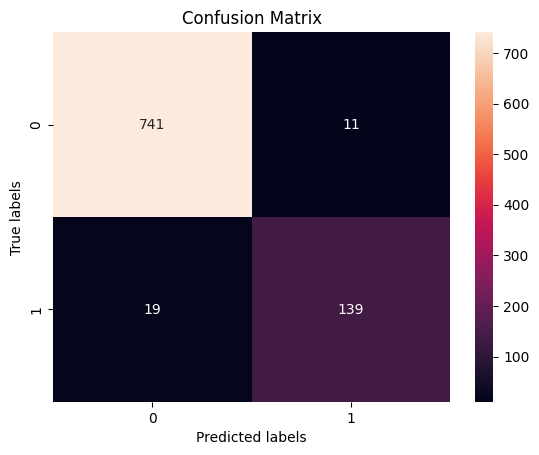

In [39]:
cm = confusion_matrix(class_true, class_predict)
print(cm)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Overall accuracy = (741+139)/(741+139+11+19) = 0.967 = 0.97, matching the classification report

Class 0:
- Recall = 0.99
- Precision = 0.97

Class 1:
- Recall = 0.88
- Precision = 0.93

**2. Report how often your model encountered out-of-vocabulary words in the test set. Were any test items skipped (not classified) due to this problem?**

In [40]:
test_out_of_vocab = dict()
for i in range(len(test)):
    text = test.loc[i, "textPreprocessed"]
    text_tokens = return_tokens(text)
    tokens_out_of_vocab = 0

    for token in text_tokens:
        if token not in vocabulary:
            tokens_out_of_vocab += 1
            if token not in test_out_of_vocab.keys():
                test_out_of_vocab[token] = 1
            else:
                test_out_of_vocab[token] += 1

print(test_out_of_vocab)
print(f"Number of unique tokens not classifed = {len(test_out_of_vocab)}")
print(f"Number of instances model encountered out-of-vocab during testing = {sum(test_out_of_vocab.values())}")

{'trouble': 1, '2nite': 5, 'hmv': 1, 'law': 2, 'plot': 1, 'pie': 3, 'drivin': 3, 'realise': 1, 'hook': 3, 'nearly': 1, 'fetch': 1, 'activity': 2, 'inside': 3, 'greet': 1, 'grl': 1, 'manage': 2, '87131': 1, 'journey': 1, 'require': 2, '://': 3, 'daddy': 4, 'asleep': 4, 'market': 2, 'depend': 1, 'prabha': 1, 'wed': 2, 'title': 1, 'piece': 1, 'fault': 3, 'lift': 2, 'girlfrnd': 1, 'boston': 2, 'nyc': 2, 't-mobile': 3, '0845': 2, 'skype': 2, 'mini': 2, 'postcode': 1, 'dreams': 3, 'lmao': 2, 'armand': 1, '1956669': 2, 'possession': 2, 'feelin': 1, 'befor': 1, 'ru': 1, 'sen': 1, 'fire': 1, 'definitely': 1, 'legal': 2, 'holla': 3, 'sup': 1, 'dick': 2, 'harry': 1, 'oz': 3, 'yijue': 1, 'exactly': 2, 'bet': 1, 'esplanade': 2, 'bud': 1, 'din': 2, 'act': 3, '=d': 1, 'challenge': 1, 'wet': 1, '6hrs': 3, '7250i': 1, '0578': 2, 'annoying': 2, 'calling': 3, 'rally': 2, 'pack': 1, 'empty': 3, 'fyi': 2, '81151': 1, 'report': 1, 'gram': 1, 'lay': 2, 'yahoo': 1, 'experience': 2, 'fee': 1, 'k.': 2, 'pg': 1,

In [41]:
num_tests_skipped = len(test[test["predicted class"].isna()])
print(f"There were {num_tests_skipped} test instances skipped")

There were 0 test instances skipped


**3. Provide examples of instances classified with high low confidence using ratio of posterior likelihood for each class. Provide some examples of test instances which are:**

**a. classified scam (label=1) with high confidence**

In [42]:
result = find_top_test_ratios(test, vocabulary, prior_probs, conditional_probs, c1=1, c2=0)
for i, (text, R) in enumerate(result.items(), start=1):
    print(f"{i}.")
    print(f"Text: {text}")
    print(f"R score: {R}")
    print()

1.
Text: . . . 2 ur yes ! £ £ offer claim last chance t 250 16 mobile discount worth cs sub 3.00
R score: 1218556157491979.2

2.
Text: reply reply free re call new offer delivery phone 150 750 tomorrow try contact video min
R score: 72050987442.02776

3.
Text: ? . 4 4 u week £ txt new question name 100 draw thanks enter cash continue support an
R score: 322011806.0440202



**b. classified non-malicious (label=0) with high confidence**

In [43]:
result = find_top_test_ratios(test, vocabulary, prior_probs, conditional_probs, c1=0, c2=1)
for i, (text, R) in enumerate(result.items(), start=1):
    print(f"{i}.")
    print(f"Text: {text}")
    print(f"R score: {R}")
    print()

1.
Text: come , back back ... ... babe
R score: 3496694.2349932324

2.
Text: ? come u pick ok n
R score: 501137.3137662168

3.
Text: ok go ... change
R score: 281369.3755832117



**c. on the boundary between the 2 classes (R near 1)**

In [44]:
result = find_top_test_ratios(test, vocabulary, prior_probs, conditional_probs, c1=1, c2=0, boundary=True)
for i, (text, R) in enumerate(result.items(), start=1):
    print(f"{i}.")
    print(f"Text: {text}")
    print(f"R score: {R}")
    print()

1.
Text: 4 ! ! mate money
R score: 0.916100252108639

2.
Text: . send link picture
R score: 0.8252714568964516

3.
Text: . yes chat
R score: 1.2034878671644293



In [45]:
result = find_top_test_ratios(test, vocabulary, prior_probs, conditional_probs, c1=0, c2=1, boundary=True)
for i, (text, R) in enumerate(result.items(), start=1):
    print(f"{i}.")
    print(f"Text: {text}")
    print(f"R score: {R}")
    print()

1.
Text: 4 ! ! mate money
R score: 1.091583587820486

2.
Text: . yes chat
R score: 0.8309182230113605

3.
Text: . send link picture
R score: 1.2117225085678347



Note that here, we should expect to receive the same texts regardless of what c1 or c2 is, which is true, as shown in results.

**In addition to reporting these points, briefly interpret them. Do the model’s high and low confidence
predictions seem reasonable to you? Is one class easier to identify than the other?**

The model performs well, having high accuracy and recall/precision per class in the test set. Looking at both recall and precision factors, i.e., the f1 score, the model performs better at predicting non-malicious texts (0.98), compared to scam texts (0.90). The difference may be due to class imbalance in the training set (80/20), where non malicious texts appear more than scams. Because of less occurances of scam instances, the model might not be as well trained on the minority class where there are less examples.

The model's predictive capability can be further improved by having larger training datasets which reduce the number of unique tokens that cannot be identified in the test dataset. Fortunately, this issue did not lead to any non-classifications/skips in testing.

Additionally, the model's confidence values seem reasonable. The top 3 results in the scam predictions have extremely high confidence, and the contents of the texts reflect this confidence value, tokens such as "claim", "discount", "offer", "cash"... are indicative of scam attempts. 
While there is also high confidence in non-malicious predictions, the degree/magnitude of confidence in scam instances is much higher, where the highest R score of label=0 is approx  3,500,000, compared to approx 1.22E12 in the scam class, almost a million times larger (looking at the number of extra 0s).

In summary, based on f1, the model performs better when predicting non-malicious texts, however, looking at confidence, the model is more confident in the scam class, possibly due to more pronounced features.

## 3. Extending the model with semi-supervised training

In [46]:
unlabelled = pd.read_csv("sms_unlabelled.csv")

## 4. Supervised model evaluation